In [1]:
import time, copy, os, sys, vtk, scipy, math, csv
from pprint import pprint
from stl import mesh
import numpy as np
np.set_printoptions(threshold=np.inf)
from scipy.special import sph_harm
from scipy import special
import scipy
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
import matplotlib.tri as tri
plt.style.use('tableau-colorblind10')
plt.rcParams['text.usetex'] = True
from IPython.display import set_matplotlib_formats
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from matplotlib import cm, colors
from matplotlib.colors import LightSource
#set_matplotlib_formats('pdf') # For vectorized output of the figures
#matplotlib_inline.backend_inline.set_matplotlib_formats('pdf')
from matplotlib.ticker import LinearLocator

import pyvista as pv
from scipy.special import *

In [2]:

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])
    
def set_axes_equal_2d(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range])

    ax.set_xlim([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim([y_middle - plot_radius, y_middle + plot_radius])


## Oblate Spheroidal Coordinate (parametric form)


$$ x = a \sqrt{(\xi^2 - 1)(1-\eta^2)} \cos \phi $$
$$ y = a \sqrt{(\xi^2 - 1)(1-\eta^2)} \sin \phi $$
$$ z = a \xi \eta $$
with $\xi = \cosh \mu$ and $\eta = \cos \nu$


Or

$$ x = a \cosh \mu \cos \nu \cos \phi $$
$$ y = a \cosh \mu \cos \nu \sin \phi $$
$$ z = a \sinh \mu \sin \nu $$

Range of $0 \leq \mu < \infty$, $-\frac{\pi}{2} \leq \nu < \frac{\pi}{2}$ and $0 \leq \phi \leq 2\pi$




## Oblate harmonics

\begin{equation}\label{eqn:general_sol}
    % \begin{pmatrix}
    %     x(\zeta, \theta, \phi)\\
    %     y(\zeta, \theta, \phi)\\
    %     z(\zeta, \theta, \phi)
    % \end{pmatrix} 
\hat{f}(\zeta = const, \theta, \phi) = \sum_{n=0}^{n_{max}} \sum_{m=-n}^{n} N_m^n \ A_m^n \ P_m^n\left(\xi_2(\theta)\right) \ e^{i m \phi}. 
\end{equation}

Here $\xi_2 =  sin(\theta)$ and
\begin{equation}
    N_m^n = \sqrt{\frac{(2n+1)}{4\pi} \ \frac{(n-m)!}{(n+m)!}}.
\end{equation}

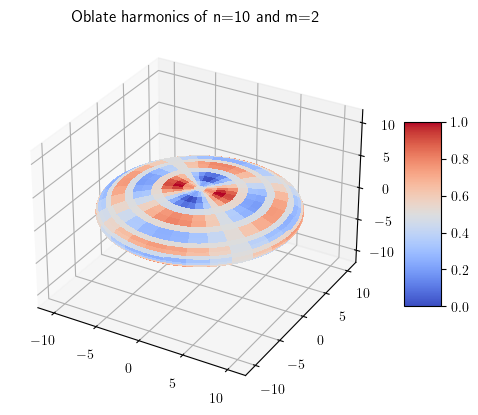

Max vs min radii:  0.6198754297808029 -0.6189968776543056


In [3]:
subdivgrid = 60
nu = np.linspace(-np.pi/2, np.pi/2, num=subdivgrid)
phi = np.linspace(0, 2.0*np.pi, num=subdivgrid)
nu, phi = np.meshgrid(nu, phi)

mu = 0.3
a = 10;
n, m = 10, 2

x = a * np.cosh(mu) * np.cos(nu) * np.cos(phi)
y = a * np.cosh(mu) * np.cos(nu) * np.sin(phi)
z = a * np.sinh(mu) * np.sin(nu)


fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# The basis functions evaluation
N_mn = np.sqrt( (2*n + 1) * factorial(n - m) / (4*np.pi * factorial(n+m)))
r = N_mn * (np.exp(-1j * m * phi) * scipy.special.lpmv(m, n, np.sin(nu))).real



# Plot the surface.
scamap = plt.cm.ScalarMappable(cmap=cm.coolwarm)
fcolors = scamap.to_rgba(r)
surf = ax.plot_surface(x, y, z, facecolors = fcolors, cmap=cm.coolwarm,
                       linewidth=0., antialiased=False, edgecolor="black")

fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Oblate harmonics of n={} and m={}".format(n, m))
set_axes_equal(ax)
plt.show()

print("Max vs min radii: ", r.max(), r.min())

## Prolate Spheroidal Coordinate (parametric form)


$$ x = a \sqrt{(\xi^2 - 1)(1-\eta^2)} \cos \phi $$
$$ y = a \sqrt{(\xi^2 - 1)(1-\eta^2)} \sin \phi $$
$$ z = a \xi \eta $$
with $\xi = \cosh \mu$ and $\eta = \cos \nu$


Or

$$ x = a \sinh \mu \sin \nu \cos \phi $$
$$ y = a \sinh \mu \sin \nu \sin \phi $$
$$ z = a \cosh \mu \cos \nu $$

Range of $0 \leq \mu < \infty$, $0 \leq \nu < \pi$ and $0 \leq \phi \leq 2\pi$


## Prolate harmonics

\begin{equation}\label{eqn:general_sol}
    % \begin{pmatrix}
    %     x(\zeta, \theta, \phi)\\
    %     y(\zeta, \theta, \phi)\\
    %     z(\zeta, \theta, \phi)
    % \end{pmatrix} 
\hat{f}(\zeta = const, \theta, \phi) = \sum_{n=0}^{n_{max}} \sum_{m=-n}^{n} N_m^n \ A_m^n \ P_m^n\left(\xi_2(\theta)\right) \ e^{i m \phi}. 
\end{equation}

Here $\xi_2 =  cos(\theta)$ and
\begin{equation}
    N_m^n = \sqrt{\frac{(2n+1)}{4\pi} \ \frac{(n-m)!}{(n+m)!}}.
\end{equation}

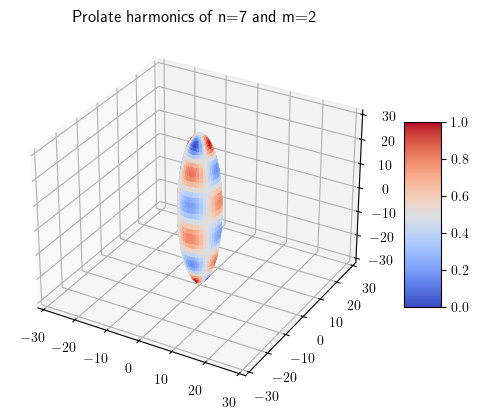

Max vs min radii:  0.5384981633048297 -0.5384981633048295


In [4]:
subdivgrid = 90
nu = np.linspace(0, np.pi, num=subdivgrid)
phi = np.linspace(0, 2*np.pi, num=subdivgrid)
nu, phi = np.meshgrid(nu, phi)

mu = 0.2
a = 30;
n, m = 7, 2

x = a * np.sinh(mu) * np.sin(nu) * np.cos(phi)
y = a * np.sinh(mu) * np.sin(nu) * np.sin(phi)
z = a * np.cosh(mu) * np.cos(nu)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# The basis functions evaluation
N_mn = np.sqrt( (2*n + 1) * factorial(n - m) / (4*np.pi * factorial(n+m)))
r = N_mn * (np.exp(-1j * m * phi) * scipy.special.lpmv(m, n, np.cos(nu))).real

# Plot the surface and basis.
scamap = plt.cm.ScalarMappable(cmap=cm.coolwarm)
fcolors = scamap.to_rgba(r)
surf = ax.plot_surface(x, y, z, facecolors = fcolors, cmap=cm.coolwarm,
                       linewidth=0.0, edgecolor="black", antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title("Prolate harmonics of n={} and m={}".format(n, m))
set_axes_equal(ax)
plt.show()

print("Max vs min radii: ", r.max(), r.min())

# Derivatives of Legendre
## Spheroidal harmonics

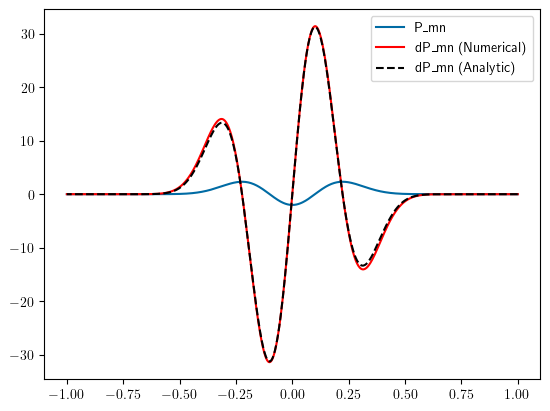

In [5]:
m, n = 48, 50

# For oblate
z = np.linspace(-np.pi/2, np.pi/2, num=1000)
x = np.sin(z)

# For prolate/spherical
z = np.linspace(0, np.pi, num=1000)
x = np.cos(z)

N_mn = np.sqrt( (2*n + 1) * factorial(abs(n-m)) / factorial(n+m) )

y = N_mn * scipy.special.lpmv(m, n, x)
y_p = np.gradient(N_mn * scipy.special.lpmv(m, n, x), x)

# Source: "On the Computation af Derivatives of Legendre Functions", W. Bosch (2000). 
y_p_a = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, x) - scipy.special.lpmv(m+1, n, x) )


plt.plot(x, y, label = "P_mn")
plt.plot(x, y_p, "r", label = "dP_mn (Numerical)")
plt.plot(x, y_p_a, "k--",label = "dP_mn (Analytic)")
plt.legend()

# Derivatives of Legendre
## Spheroidal cap harmonics

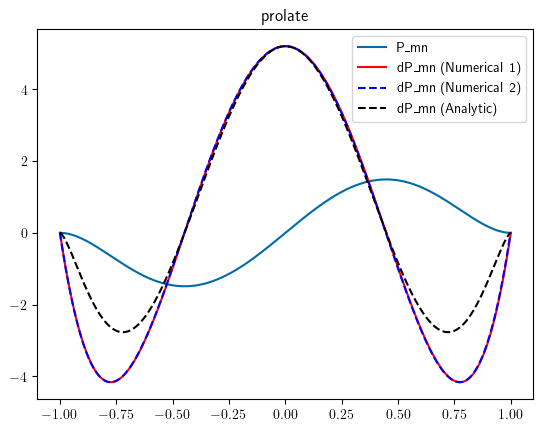

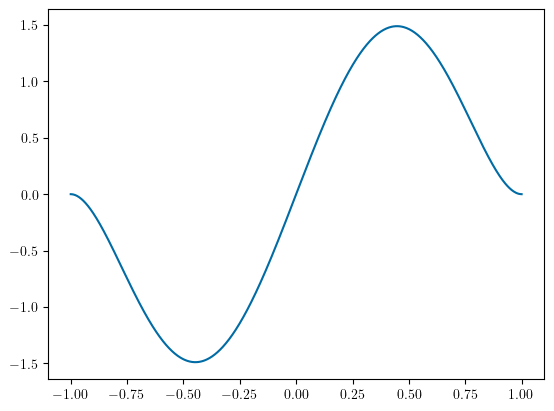

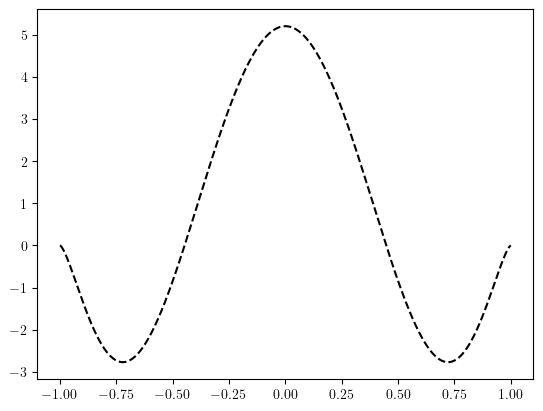

In [6]:
subdiv = 1000

m, n = 4, 5

spheroid_type = "prolate"
#spheroid_type = "oblate"

if spheroid_type == "oblate":
    # For oblate
    a, b = 0, 1 # oblate
    z = np.linspace(-np.pi/2, 0, num=subdiv)
    x = 2*np.sin(z) - 1
elif spheroid_type == "prolate":
    # For prolate/spherical
    a, b = 1, 0 # prolate
    z = np.linspace(0, np.pi/2, num=subdiv)
    x = 1 - 2*np.cos(z)

N_mn = np.sqrt( ((2*n + 1) / abs(b - a)) * factorial(n - m) / factorial(n + m) )

y = N_mn * scipy.special.lpmv(m, n, x)
y_p = np.gradient(N_mn * scipy.special.lpmv(m, n, x), x, edge_order=2)
y_p2 = np.diff(y) / np.diff(x)

# Source: "On the Computation af Derivatives of Legendre Functions", W. Bosch (2000). 
y_p_a = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, x) - scipy.special.lpmv(m+1, n, x) )


plt.plot(x, y, label = "P_mn")
plt.plot(x, y_p, "r", label = "dP_mn (Numerical 1)")
plt.plot(x[:-1], y_p2, "b--",label = "dP_mn (Numerical 2)")
plt.plot(x, y_p_a, "k--",label = "dP_mn (Analytic)")
plt.title(spheroid_type)
plt.legend()
plt.show()
plt.plot(x, y, label = "P_mn")
plt.show()
plt.plot(x, y_p_a, "k--",label = "dP_mn (Analytic)")


# Orthonormality of Basis functions

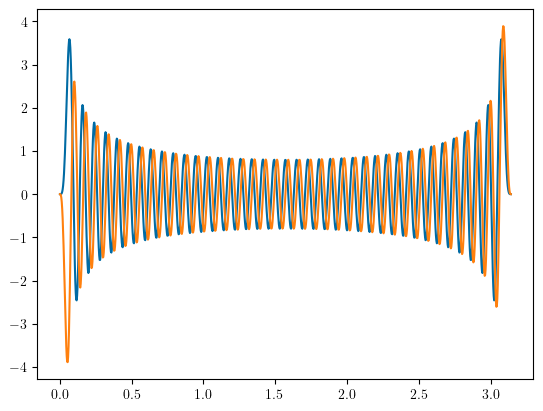

-3.1748304674965807e-16


In [7]:
subdiv = 1000

m1, n1 = 4, 80
m2, n2 = 3, 80

spheroid_type = "prolate"
spheroid_type = "spherical"
#spheroid_type = "oblate"

if spheroid_type == "oblate":
    # For oblate
    a, b = 0, 1 # oblate
    z = np.linspace(-np.pi/2, 0, num=subdiv)
    x = 2*np.sin(z) - 1
elif spheroid_type == "prolate":
    # For prolate/spherical
    a, b = 1, 0 # prolate
    z = np.linspace(0, np.pi/2, num=subdiv)
    x = 1 - 2*np.cos(z)
elif spheroid_type == "spherical":
    # For prolate/spherical
    a, b = -1, 1 # prolate
    z = np.linspace(0, np.pi, num=subdiv)
    x = np.cos(z)

N_mn1 = np.sqrt( ((2*n1 + 1) / abs(b - a)) * factorial(n1 - m1) / factorial(n1 + m1) )
N_mn2 = np.sqrt( ((2*n2 + 1) / abs(b - a)) * factorial(n2 - m2) / factorial(n2 + m2) )

y1 = N_mn1 * scipy.special.lpmv(m1, n1, x)
y2 = N_mn2 * scipy.special.lpmv(m2, n2, x)

plt.plot(z, y1, label="n = {}, m = {}".format(n1, m1))
plt.plot(z, y2, label="n = {}, m = {}".format(n1, m1))
plt.show()

orth = np.inner(y1, y2) / y1.size
print(orth)

# For spheroidal harmonics
## Proof that $x = cos \theta$ := $x = sin \theta$

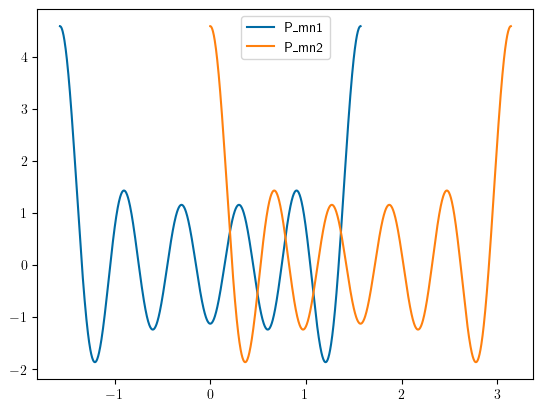

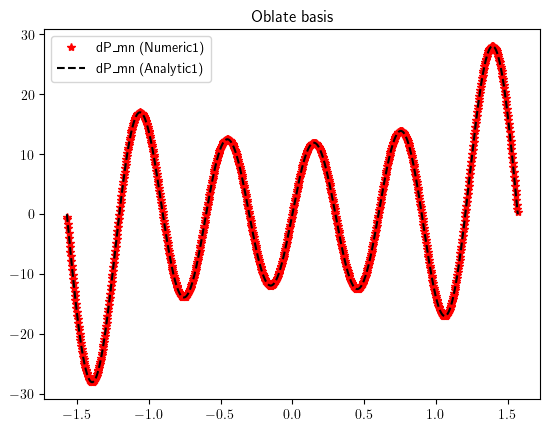

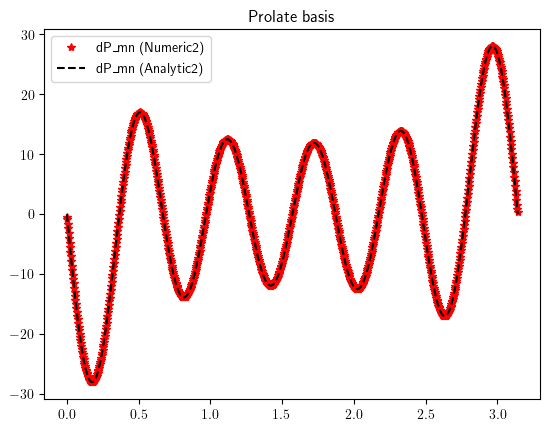

In [8]:
m, n = 0, 10

# For oblate
z1 = np.linspace(-np.pi/2, np.pi/2, num=1000)
x1 = np.sin(z1)

# For prolate/spherical
z2 = np.linspace(0, np.pi, num=1000)
x2 = np.cos(z2)

N_mn = np.sqrt( (2*n + 1) * factorial(abs(n-m)) / factorial(n+m) )

y1 = N_mn * scipy.special.lpmv(m, n, x1)
y_p1 = np.gradient(N_mn * scipy.special.lpmv(m, n, x1), x1)

y2 = N_mn * scipy.special.lpmv(m, n, x2)
y_p2 = np.gradient(N_mn * scipy.special.lpmv(m, n, x2), x2)

# Source: "On the Computation af Derivatives of Legendre Functions", W. Bosch (2000). 
y_p_a1 = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, x1) - scipy.special.lpmv(m+1, n, x1) )
y_p_a2 = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, x2) - scipy.special.lpmv(m+1, n, x2) )


plt.plot(z1, y1, label = "P_mn1")
plt.plot(z2, y2, label = "P_mn2")
#plt.plot(x1, y_p_a1, "k--",label = "dP_mn (Analytic1)")
#plt.plot(x2, y_p_a2, "g--",label = "dP_mn (Analytic2)")
plt.legend()
plt.show()




y_p1_z = np.gradient(N_mn * scipy.special.lpmv(m, n, x1), z1)
plt.plot(z1, y_p1_z, "r*",label = "dP_mn (Numeric1)")
plt.plot(z1, y_p_a1, "k--",label = "dP_mn (Analytic1)")
plt.title("Oblate basis")
plt.legend()
plt.show()




y_p2_z = np.gradient(N_mn * scipy.special.lpmv(m, n, x2), z2)
plt.plot(z2, y_p2_z, "r*",label = "dP_mn (Numeric2)")
plt.plot(z2, -y_p_a2, "k--",label = "dP_mn (Analytic2)")
plt.title("Prolate basis")
plt.legend()

-4.547473508864641e-16


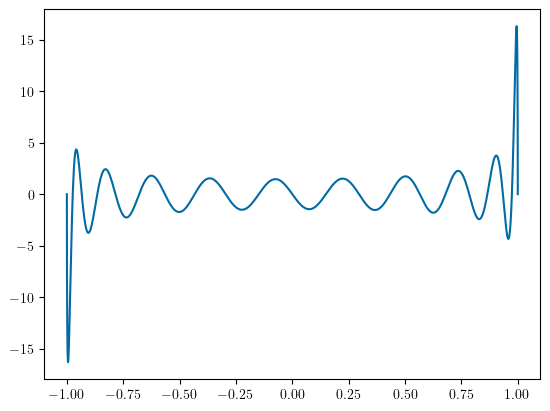

In [9]:
y_p_lol = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, x1) - scipy.special.lpmv(m+1, n, x1) ) * scipy.special.lpmv(m, n, x1)
plt.plot(x1, y_p_lol)

print(y_p_lol.sum()/len(y_p_lol))

/home/mahmoud/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


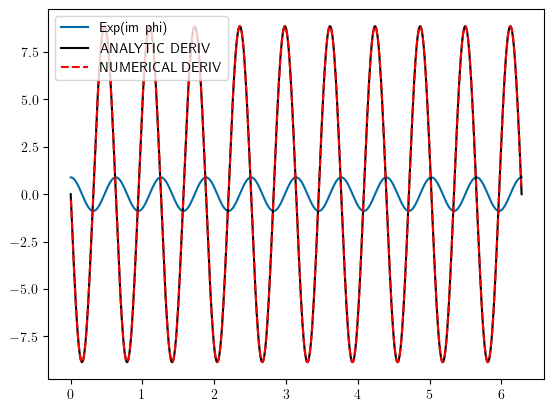

In [10]:
m = 10

# For oblate
phi = np.linspace(0, 2 * np.pi, num=1000)

N_mn_phi = np.sqrt( 1 / 4 * np.pi )

L_m = N_mn_phi * np.exp(1j * m * phi)

L_m_n = N_mn_phi * 1j * m * np.exp(1j * m * phi)

L_p_n = np.gradient(L_m, phi)


plt.plot(phi, L_m, label="Exp(im phi)")
plt.plot(phi, L_m_n, "k", label="ANALYTIC DERIV")
plt.plot(phi, L_p_n, "--r", label="NUMERICAL DERIV")
#plt.plot(phi[0:-1], L_p_n2, "--g", label="NUMERICAL DERIV")
plt.legend()

# For hemispheroidal harmonics
## Check the derivatives


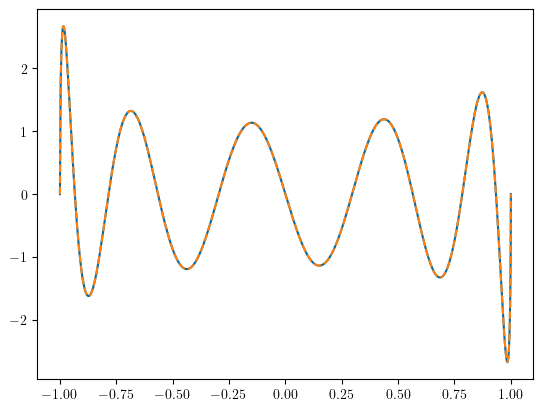

In [11]:
m, n = 1, 10

# For oblate
z1 = np.linspace(0, np.pi/2, num=1000)
#(-1+2*np.sin(nu))
xx1 = 2*np.sin(z1) -1

# For prolate/spherical
z2 = np.linspace(0, np.pi/2, num=1000)
#-2*np.cos(nu)+1
xx2 = -2*np.cos(z2)+1

N_mn = np.sqrt( (2*n + 1) * factorial(abs(n-m)) / factorial(n+m) )

yy1 = N_mn * scipy.special.lpmv(m, n, xx1)
yy2 = N_mn * scipy.special.lpmv(m, n, xx2)
yy_p1 = np.gradient(yy1, xx1)
yy_p2 = np.gradient(yy2, xx2)

plt.plot(xx1, yy1, label = "P_mn1")
plt.plot(xx2, yy2, "--",  label = "P_mn2")

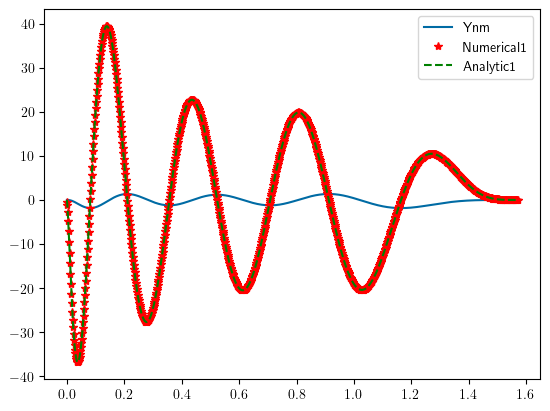

In [12]:
m, n = 5, 11

# For oblate
epsilon = 1E-11
z1 = np.linspace(0+epsilon, np.pi/2-epsilon, num=1000)
#(-1+2*np.sin(nu))
xx1 = 2*np.sin(z1) -1

# For prolate/spherical
#z2 = np.linspace(0+0.1, np.pi/2-0.1, num=1000)
#-2*np.cos(nu)+1
#xx2 = -2*np.cos(z2)+1

N_mn = np.sqrt( (2*n + 1) * factorial(abs(n-m)) / factorial(n+m) )

y1 = N_mn * scipy.special.lpmv(m, n, xx1)
#y2 = N_mn * scipy.special.lpmv(m, n, z2)
y_p1 = np.gradient(y1, z1)
#y_p2 = np.gradient(y2, z2)

# Source: "On the Computation af Derivatives of Legendre Functions", W. Bosch (2000). 
#y_p_a11 = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, xx1) - scipy.special.lpmv(m+1, n, xx1) ) * 2 * np.cos(z1) / (np.sqrt(1-xx1**2))

y_p_a11 = N_mn * 2 * np.cos(z1) * ( m * xx1 / (1- xx1**2) *  scipy.special.lpmv(m, n, xx1) + scipy.special.lpmv(m+1, n, xx1) / np.sqrt(1-xx1**2) )


#y_p_a22 = N_mn * 0.5 * ( (n+m) * (n - m +1) * scipy.special.lpmv(m-1, n, xx2) - scipy.special.lpmv(m+1, n, xx2) ) * np.sin(z2) * 2 / (np.sqrt(1 - xx2**2)) 

plt.plot(z1, y1, label="Ynm")
plt.plot(z1, y_p1, "r*", label = "Numerical1")
plt.plot(z1, -y_p_a11, "g--", label = "Analytic1")
plt.legend()
plt.show()

#plt.plot(z2, yy2, "r*",  label = "Numerical2")
#plt.plot(z2, y_p_a22, "g--",  label = "Analytic2")
#plt.legend()

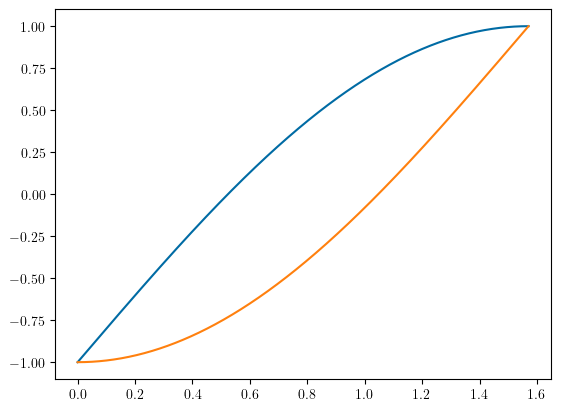

In [13]:
plt.plot(z1, xx1)
plt.plot(z2, xx2)

In [14]:
n, m = 10, 5


print(factorial(n+m)/factorial(n-m) * (-1)**m)

-10897286400.0


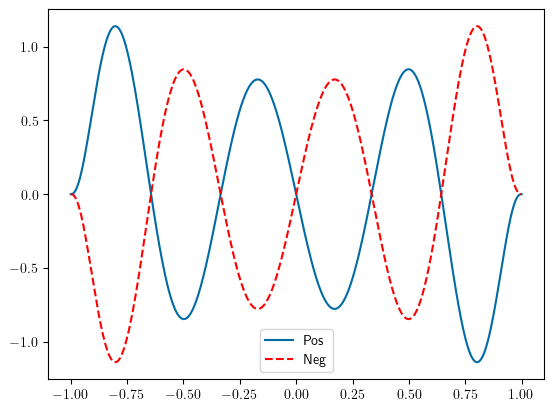

In [15]:
n, m = 10, 5

y_pos = N_mn * scipy.special.lpmv(m, n, xx1)
y_neg =  (-1)**m * N_mn * scipy.special.lpmv(m, n, xx1)


plt.plot(xx1, y_pos, label="Pos")
plt.plot(xx1, y_neg, "r--", label="Neg")
plt.legend()


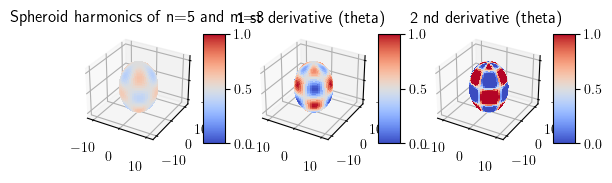

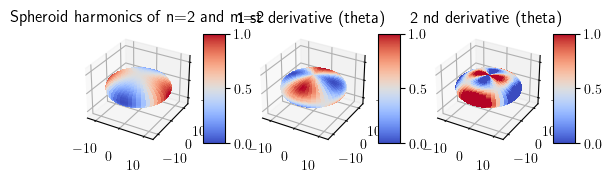

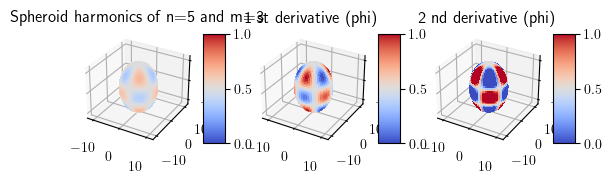

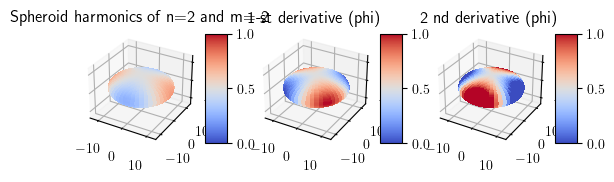

In [101]:
def derivative_spheroids_legendre_old(n, m, order, theta, spheroid_type):
    """
    Derive the associated Legendre polynomials with respect to \theta.
    n, m (int): are the degree and order of the polynomial.
    order (int): is the order of derivative 1: 1st derivative, 2: 2nd derivative, ...etc.
    theta (float array): theta angles in radian.
    spheroid_type: prolate or obalte functions.
    """
    m = abs(m) # Just a check
    
    if spheroid_type == "prolate":
        x = np.cos(theta); sgn_fact = 1;
    elif spheroid_type == "oblate":
        x = np.sin(theta); sgn_fact = -1;
    
    if order == 1:
        return sgn_fact * 0.5 * ( scipy.special.lpmv(m+1, n, x) - (n + m) * (n-m + 1) * 
                                 scipy.special.lpmv(m-1, n, x))
    elif order > 1:
        return derivative_spheroids_legendre(n, m, order-1, theta, spheroid_type)
    

def derivative_spheroids_legendre(n, m, order, theta, spheroid_type):
    """
    Derive the associated Legendre polynomials with respect to \theta.
    n, m (int): are the degree and order of the polynomial.
    order (int): is the order of derivative 1: 1st derivative, 2: 2nd derivative, ...etc.
    theta (float array): theta angles in radian.
    spheroid_type: prolate or obalte functions.
    * Tested only up to order = 2 *
    """
    #if m < 0:
    #    m = 0 # Just a check
    
    if spheroid_type == "prolate":
        x = np.cos(theta); sgn_fact = 1;
    elif spheroid_type == "oblate":
        x = np.sin(theta); sgn_fact = -1;
    
    if order == 1:
        return sgn_fact * 0.5 * ( scipy.special.lpmv(m+1, n, x) - (n + m) * (n-m + 1) *
                                 scipy.special.lpmv(m-1, n, x))
    elif order > 1:
        return sgn_fact * 0.5 * ( derivative_spheroids_legendre(n, m+1, order-1, theta, spheroid_type) - 
                (n + m) * (n-m + 1) * derivative_spheroids_legendre(n, m-1, order-1, theta, spheroid_type) )

def derivative_spheroidal_theta(n, m, order, theta, phi, spheroid_type):
    pass

def draw_derivative_spheroidal_theta(n, m, spheroid_type,
                                     subdivgrid = 200, mu = 0.6, a = 10):
    # For m => 0
    if spheroid_type == "oblate":
        theta = np.linspace(-np.pi/2, np.pi/2, num=subdivgrid)
        phi = np.linspace(0, 2.0*np.pi, num=subdivgrid)
        theta, phi = np.meshgrid(theta, phi)
        x = a * np.cosh(mu) * np.cos(theta) * np.cos(phi)
        y = a * np.cosh(mu) * np.cos(theta) * np.sin(phi)
        z = a * np.sinh(mu) * np.sin(theta)    
        r = (np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.sin(theta))).real
        
    if spheroid_type == "prolate":
        theta = np.linspace(0, np.pi, num=subdivgrid)
        phi = np.linspace(0, 2*np.pi, num=subdivgrid)
        theta, phi = np.meshgrid(theta, phi)
        x = a * np.sinh(mu) * np.sin(theta) * np.cos(phi)
        y = a * np.sinh(mu) * np.sin(theta) * np.sin(phi)
        z = a * np.cosh(mu) * np.cos(theta)
        r = (np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.cos(theta))).real
        
    dr = (derivative_spheroids_legendre(n, m, 1, theta, spheroid_type) * 
         np.exp(1j * m * phi)).real
    
    ddr = (derivative_spheroids_legendre(n, m, 2, theta, spheroid_type) * 
         np.exp(1j * m * phi)).real
    
    # The basis functions evaluation
    N_mn = np.sqrt( (2*n + 1) * factorial(n - m) / (4*np.pi * factorial(n+m)))

    r *= N_mn
    dr *= N_mn
    ddr *= N_mn
    
    fig, ax = plt.subplots(1, 3, subplot_kw={"projection": "3d"})
    scamap = plt.cm.ScalarMappable(cmap=cm.coolwarm)
    fcolors = scamap.to_rgba(dr)
    fcolors1 = scamap.to_rgba(ddr)
    fcolors2 = scamap.to_rgba(r)
    surf1 = ax[1].plot_surface(x, y, z, facecolors = fcolors, cmap=cm.coolwarm,
                           linewidth=0., antialiased=False, edgecolor="black")
    surf2 = ax[0].plot_surface(x, y, z, facecolors = fcolors2, cmap=cm.coolwarm,
                           linewidth=0., antialiased=False, edgecolor="black")
    surf3 = ax[2].plot_surface(x, y, z, facecolors = fcolors1, cmap=cm.coolwarm,
                           linewidth=0., antialiased=False, edgecolor="black")
    ax[0].set_title("Spheroid harmonics of n={} and m={}".format(n, m))
    fig.colorbar(surf1, shrink=0.3, aspect=5)
    ax[1].set_title("1 st derivative (theta)")
    fig.colorbar(surf2, shrink=0.3, aspect=5)
    ax[2].set_title("2 nd derivative (theta)")
    fig.colorbar(surf3, shrink=0.3, aspect=5)
    set_axes_equal(ax[0])
    set_axes_equal(ax[1])
    set_axes_equal(ax[2])
    plt.show()

def draw_derivative_spheroidal_phi(n, m, spheroid_type,
                                     subdivgrid = 200, mu = 0.6, a = 10):
    # For m => 0
    if spheroid_type == "oblate":
        theta = np.linspace(-np.pi/2, np.pi/2, num=subdivgrid)
        phi = np.linspace(0, 2.0*np.pi, num=subdivgrid)
        theta, phi = np.meshgrid(theta, phi)
        x = a * np.cosh(mu) * np.cos(theta) * np.cos(phi)
        y = a * np.cosh(mu) * np.cos(theta) * np.sin(phi)
        z = a * np.sinh(mu) * np.sin(theta)    
        r = (np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.sin(theta))).real
        dr = (1j * m * np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.sin(theta))).real
        ddr = -1 * m**2 * (np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.sin(theta))).real
        
    if spheroid_type == "prolate":
        theta = np.linspace(0, np.pi, num=subdivgrid)
        phi = np.linspace(0, 2*np.pi, num=subdivgrid)
        theta, phi = np.meshgrid(theta, phi)
        x = a * np.sinh(mu) * np.sin(theta) * np.cos(phi)
        y = a * np.sinh(mu) * np.sin(theta) * np.sin(phi)
        z = a * np.cosh(mu) * np.cos(theta)
        r = (np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.cos(theta))).real
        dr = (1j * m * np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.cos(theta))).real
        ddr = -1 * m**2 * (np.exp(1j * m * phi) * scipy.special.lpmv(m, n, np.cos(theta))).real
    
    # The basis functions evaluation
    N_mn = np.sqrt( (2*n + 1) * factorial(n - m) / (4*np.pi * factorial(n+m)))

    r *= N_mn
    dr *= N_mn
    ddr *= N_mn
    
    fig, ax = plt.subplots(1, 3, subplot_kw={"projection": "3d"})
    scamap = plt.cm.ScalarMappable(cmap=cm.coolwarm)
    fcolors = scamap.to_rgba(dr)
    fcolors1 = scamap.to_rgba(ddr)
    fcolors2 = scamap.to_rgba(r)
    surf1 = ax[1].plot_surface(x, y, z, facecolors = fcolors, cmap=cm.coolwarm,
                           linewidth=0., antialiased=False, edgecolor="black")
    surf2 = ax[0].plot_surface(x, y, z, facecolors = fcolors2, cmap=cm.coolwarm,
                           linewidth=0., antialiased=False, edgecolor="black")
    surf3 = ax[2].plot_surface(x, y, z, facecolors = fcolors1, cmap=cm.coolwarm,
                           linewidth=0., antialiased=False, edgecolor="black")
    ax[0].set_title("Spheroid harmonics of n={} and m={}".format(n, m))
    fig.colorbar(surf1, shrink=0.3, aspect=5)
    ax[1].set_title("1 st derivative (phi)")
    fig.colorbar(surf2, shrink=0.3, aspect=5)
    ax[2].set_title("2 nd derivative (phi)")
    fig.colorbar(surf3, shrink=0.3, aspect=5)
    set_axes_equal(ax[0])
    set_axes_equal(ax[1])
    set_axes_equal(ax[2])
    plt.show()


draw_derivative_spheroidal_theta(n=5, m=3, spheroid_type="prolate")

draw_derivative_spheroidal_theta(n=2, m=2, spheroid_type="oblate")


draw_derivative_spheroidal_phi(n=5, m=3, spheroid_type="prolate")

draw_derivative_spheroidal_phi(n=2, m=2, spheroid_type="oblate")

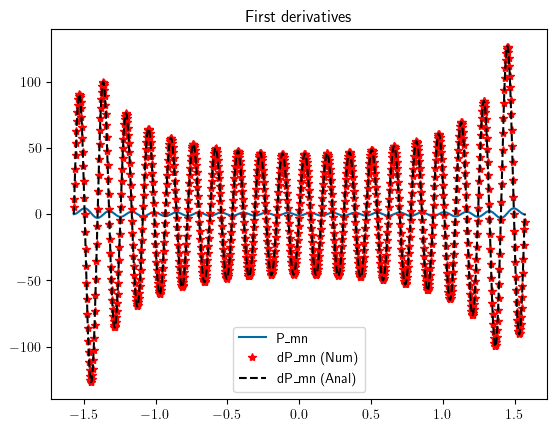

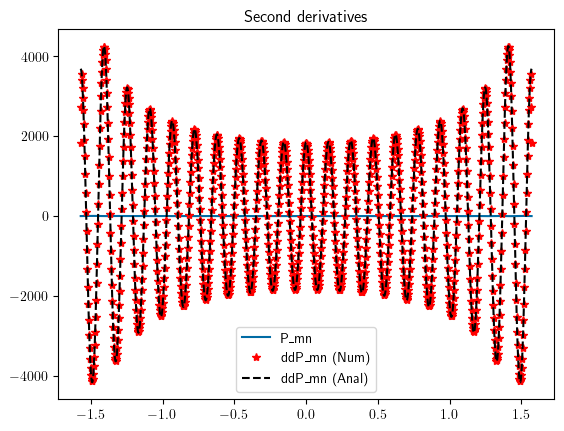

In [104]:
m, n = 2, 40
deriv_order = 2


spheroid_type = "prolate"
spheroid_type = "oblate"

# For oblate
if spheroid_type == "oblate":
    theta = np.linspace(-np.pi/2, np.pi/2, num=1000)
    x = np.sin(theta)

if spheroid_type == "prolate":
    theta = np.linspace(0, np.pi, num=1000)
    x = np.cos(theta)

N_mn = np.sqrt( (2*n + 1) * factorial(abs(n-m)) / factorial(n+m) )

P_harm = N_mn * scipy.special.lpmv(m, n, x)

# Numerical derivatives
dP_harm_theta = np.gradient(P_harm, theta)
ddP_harm_theta = np.gradient(dP_harm_theta, theta)

# Analytic derivatives
dP_harm_theta2 = N_mn * derivative_spheroids_legendre(n, m, 1, theta, spheroid_type)
ddP_harm_theta2 = N_mn * derivative_spheroids_legendre(n, m, 2, theta, spheroid_type)

plt.plot(theta, P_harm, label = "P_mn")
plt.plot(theta, dP_harm_theta, "r*",  label = "dP_mn (Num)")
plt.plot(theta, dP_harm_theta2, "k--",  label = "dP_mn (Anal)")
plt.legend()
plt.title("First derivatives")
plt.show()

plt.plot(theta, P_harm, label = "P_mn")
plt.plot(theta, ddP_harm_theta, "r*",  label = "ddP_mn (Num)")
plt.plot(theta, ddP_harm_theta2, "k--",  label = "ddP_mn (Anal)")
plt.legend()
plt.title("Second derivatives")
plt.show()